In [1]:
from tqdm.notebook import tqdm
from functools import partial

import jax
from jax import numpy as jnp
import numpy as np
import haiku as hk
import optax

from dart import dataset, VirtualRadar, fields

In [2]:
sensor = VirtualRadar.from_config("data/sim_96.json")

gt = dataset.gt_map("data/map.mat")
ds = dataset.image_traj("data/traj.mat", "data/sim_96.npz")
ds = ds.shuffle(10000, reshuffle_each_iteration=True).batch(32)

render = partial(sensor.render, sigma=gt)
render = jax.jit(jax.vmap(render))

In [3]:
def forward(poses):
    key = hk.next_rng_key()
    keys = jax.random.split(key, poses.v.shape[0])
    sigma = fields.SimpleGrid(
        (100, 100, 100), lower=gt.lower, resolution=gt.resolution * 2)
    return jax.vmap(partial(sensor.render, sigma=sigma))(keys, pose=poses)

dart = hk.transform(forward)

data_trace = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0][0])
params = dart.init(jax.random.PRNGKey(42), data_trace)
key = jax.random.PRNGKey(42)

optimizer = optax.adamw(optax.exponential_decay(
    0.01, 500, 0.01, transition_begin=100, end_value=0.001))
opt_state = optimizer.init(params)

def step(rng, pose, y_true, params, opt_state):

    def loss_func(params):
        y_pred = dart.apply(params, rng, pose)
        return jnp.sum((y_true - y_pred)**2) / y_pred.shape[0]
        # return jnp.mean((y_true - y_pred)**2)
    
    loss, grads = jax.value_and_grad(loss_func)(params)
    loss_clip = jax.tree_util.tree_map(jnp.nan_to_num, grads)
    updates, opt_state = optimizer.update(loss_clip, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = jax.tree_util.tree_map(
        partial(jnp.clip, a_min=0.0, a_max=1.0), params)

    return params, opt_state, loss

for epoch in range(5):
    with tqdm(ds, unit="batch", desc="Epoch {}".format(epoch)) as _epoch:
        avg = 0
        for i, batch in enumerate(_epoch):
            key, rng = jax.random.split(key, 2)
            pose, y_true = jax.tree_util.tree_map(jnp.array, batch)
            params, opt_state, loss = jax.jit(step)(
                rng, pose, y_true, params, opt_state)

            avg = (avg * i + loss) / (i + 1)
            _epoch.set_postfix(loss=avg)

2022-12-11 18:56:46.938786: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB (rounded to 2415919104)requested by op 
2022-12-11 18:56:46.938961: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:492] **********************************************************************************************______
2022-12-11 18:56:46.939018: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2415919104 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.25GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.25GiB
     preallocated temp allocation:         0B
                 total allocation:    4.50GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2415919104 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.25GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.25GiB
     preallocated temp allocation:         0B
                 total allocation:    4.50GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.25GiB
		Entry Parameter Subshape: s32[32,96,96,256,8]
		==========================

	Buffer 2:
		Size: 2.25GiB
		Operator: op_name="jit(add)/jit(main)/add" source_file="/home/tianshu/dart/dart/spatial.py" source_line=42
		XLA Label: fusion
		Shape: s32[32,96,96,256,8]
		==========================

	Buffer 3:
		Size: 4B
		Entry Parameter Subshape: s32[]
		==========================



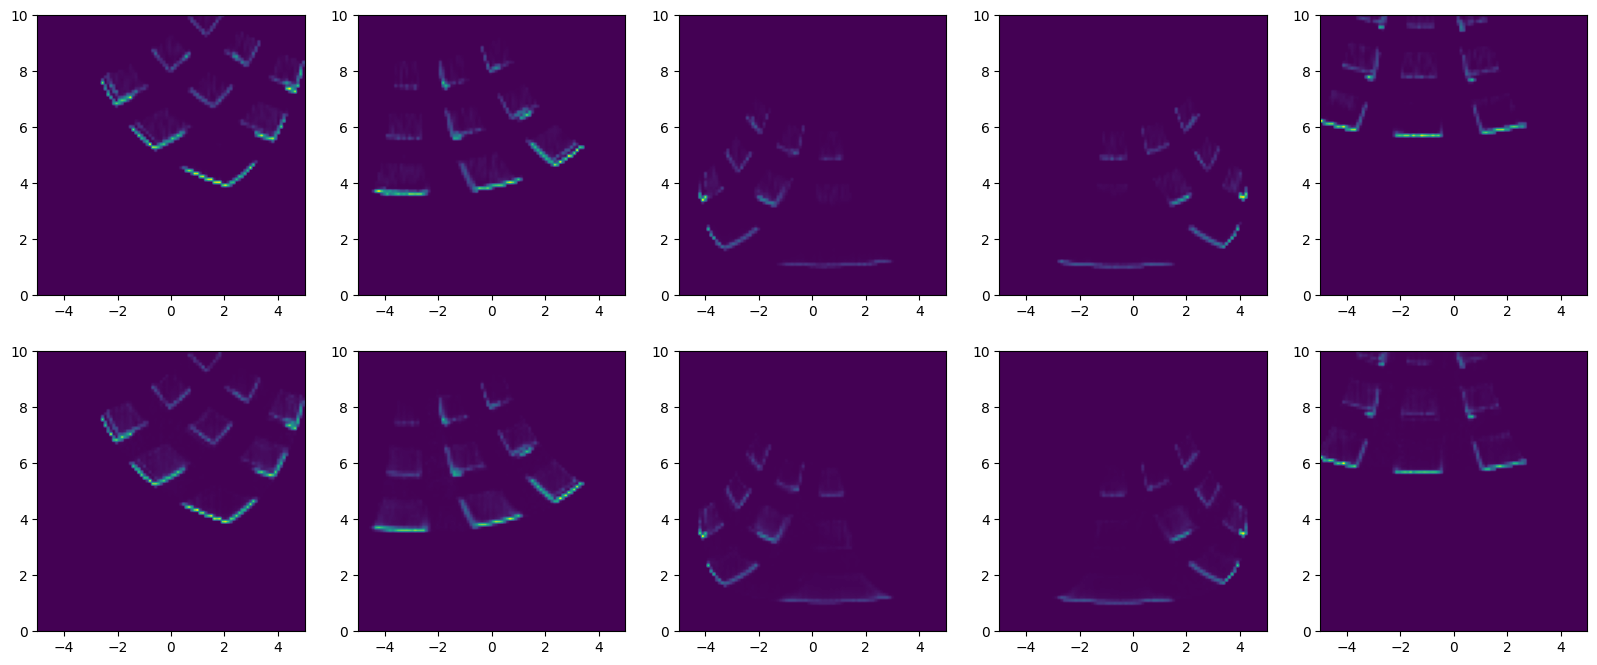

In [ ]:
from matplotlib import pyplot as plt

batch = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0])
pose, y_true = batch

fig, axs = plt.subplots(2, 5, figsize=(20, 8))

extents = np.load("data/sim_96_occ.npz")['extents']

y_pred = dart.apply(params, jax.random.PRNGKey(42), pose)
for y1, y2, col in zip(y_true, y_pred, axs.T):
    col[0].imshow(y1, extent=extents, aspect='auto', origin='lower')
    col[1].imshow(y2, extent=extents, aspect='auto', origin='lower')

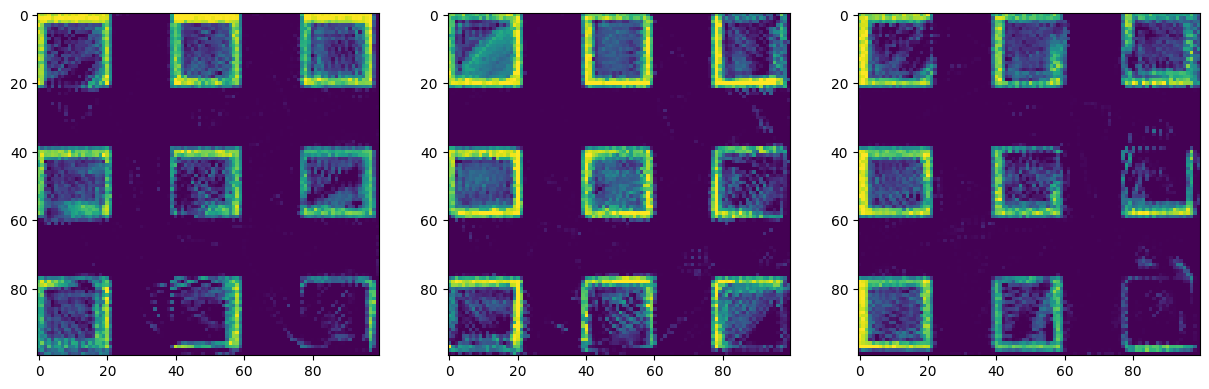

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([10, 50, 90], axs):
    ax.imshow(params['simple_grid']['grid'][:, :, layer])